In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Downsampling

In [24]:
from utils import downsample_track_data, plot_fp_act, GetAzimuth, g
import time

In [18]:
downsamp_flight_tracks, downsamp_flight_plans, flight_plans, flight_plans_util, flight_tracks = downsample_track_data(path_to_fp = '/media/storage/DATA/DeepTPdata/cleaned_FP_tracks.CSV',
                                                                       path_to_fp_util = '/media/storage/DATA/DeepTPdata/IAH_BOS_Act_Flt_Trk_20130101_1231.CSV',
                                                                       path_to_track = '/media/storage/DATA/DeepTPdata/New_IAHBOS2013.csv',
                                                                       downsamp_rate_ft = 2,
                                                                       downsamp_rate_fp = 1.05)

In [32]:
FID

[20130101632288,
 20130101635086,
 20130101663353,
 20130102708353,
 20130102717674,
 20130102719088,
 20130102726083,
 20130103780461,
 20130103781039,
 20130103808696]

In [9]:
print(flight_plans.shape)
print(downsamp_flight_plans.shape)
print(flight_tracks.shape)
print(downsamp_flight_tracks.shape)

(4008, 3)
(1429, 3)
(312624, 16)
(158831, 16)


567 flights filed flight plan FP_00001


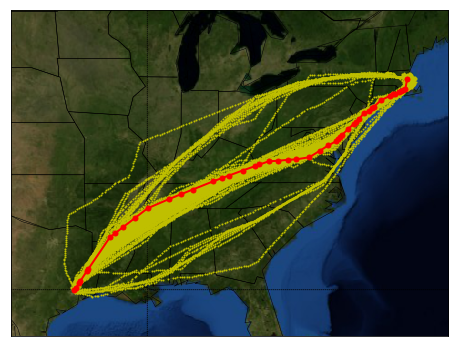

In [6]:
_, _ = plot_fp_act('FP_00001', flight_plans_util, flight_tracks, flight_plans)

567 flights filed flight plan FP_00001


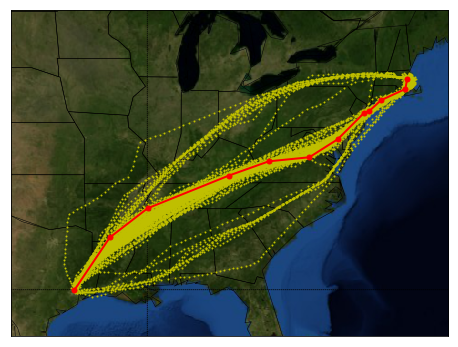

In [8]:
_, _ = plot_fp_act('FP_00001', flight_plans_util, downsamp_flight_tracks, downsamp_flight_plans)

## Associate track with wind/ temperature/wx fname

In [11]:
import re
from dateutil import parser
from scipy.spatial import cKDTree
import datetime
import pickle

In [12]:
global baseline_time
baseline_time = parser.parse('01/01/2013 0:0:0')

In [13]:
query_body = downsamp_flight_tracks.Elap_Time.apply(lambda x: (x - baseline_time).total_seconds())

In [15]:
# wind/ temperature fname

wind_fname_list = os.listdir('../../DATA/filtered_weather_data/namanl_small_npz/')
time_objs = []
trash_holder = []
wind_fname_list.sort()
for item in wind_fname_list:
    if item.endswith('.npz'):
        time_string = re.findall('\d\d\d\d\d\d\d\d_\d\d\d\d_\d\d\d', item)[0]
        time_obj = parser.parse('%s %s'%(time_string[:8], time_string[9:13])) + \
                    datetime.timedelta(hours = int(time_string[-3:]))
        time_diff = (time_obj - baseline_time).total_seconds()
        if time_diff not in trash_holder:
            trash_holder.append(time_diff)
            time_objs.append([item, time_diff])
        else:
            time_objs.pop(-1)
            time_objs.append([item, time_diff])
    else:
        pass
    
time_objs = np.array(time_objs, dtype=np.object)

In [16]:
print(len(wind_fname_list))
print(len(time_objs))

7187
5730


In [100]:
wind_ftime_tree = cKDTree(time_objs[:, -1].reshape(-1, 1))
query_dist, query_index = wind_ftime_tree.query(query_body.values.reshape(-1,1), p = 1, distance_upper_bound=6.1*3600)
valid_query = query_index<wind_ftime_tree.data.shape[0]
downsamp_flight_tracks.loc[valid_query, 'wind_fname'] = time_objs[query_index[valid_query], 0]
downsamp_flight_tracks.loc[~valid_query, 'wind_fname'] = None

In [87]:
downsamp_flight_tracks.head(3)

,FID,FlightIdx,ACID,ACT_DATE,DEP,ARR,Elap_Time,Lat,Lon,Alt,GroundSpeed,ID2,DT,Dist,Speed,CumDist,wind_fname
0,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:08:00,29.983333,-95.300000,8,159,471666-UAL386,0.0,0.000000,0.000000,0.000000,namanl_218_20130101_0000_000.npz
1,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:09:00,30.016667,-95.266667,26,253,471666-UAL386,60.0,2.647485,0.044125,2.647485,namanl_218_20130101_0000_000.npz
2,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:12:00,30.250000,-95.216667,109,300,471666-UAL386,180.0,5.077461,0.084624,16.895802,namanl_218_20130101_0000_000.npz


In [26]:
# convective weather
wx_pointer = np.load('../../DATA/NCWF/gridded_storm.npz')
start_time = wx_pointer['start_time']
unique_alt = wx_pointer['unique_alt']
with open('../../DATA/NCWF/alt_dict.pkl', 'rb') as pfile:
    alt_dict = pickle.load(pfile)

In [112]:
time_obj_wx = []
time_diff_wx = []
for obj in start_time:
    tmp_time = parser.parse('%d/%d/%d %d:00:00'%(obj[1], obj[2], obj[0], obj[3]))
    time_obj_wx.append(tmp_time)
    time_diff_wx.append((tmp_time - baseline_time).total_seconds())
time_diff_wx = np.array(time_diff_wx)
time_obj_wx = np.array(time_obj_wx)

In [116]:
wx_ftime_tree = cKDTree(time_diff_wx.reshape(-1, 1))
query_dist, query_index = wx_ftime_tree.query(query_body.values.reshape(-1,1), p = 1, distance_upper_bound=2*3600)

In [123]:
valid_query = query_index < wx_ftime_tree.data.shape[0]
downsamp_flight_tracks.loc[valid_query, 'wx_fname'] = time_obj_wx[query_index[valid_query]]
downsamp_flight_tracks.loc[~valid_query, 'wx_fname'] = np.nan
downsamp_flight_tracks.loc[valid_query, 'wx_idx'] = query_index[valid_query]
downsamp_flight_tracks.loc[~valid_query, 'wx_idx'] = np.nan

## Associate flight tracks with convective weather data

In [128]:
downsamp_flight_tracks.tail(5)

,FID,FlightIdx,ACID,ACT_DATE,DEP,ARR,Elap_Time,Lat,Lon,Alt,GroundSpeed,ID2,DT,Dist,Speed,CumDist,wind_fname,wx_fname,wx_idx
158826,20131231523303,2500,UAL418T,31-DEC-13 00:00:00,IAH,BOS,2013-12-31 23:04:00,42.183333,-70.750000,40,139,2500-UAL418T,120.0,2.992668,0.049878,1435.368255,namanl_218_20131231_1800_006.npz,NaN,NaN
158827,20131231523303,2500,UAL418T,31-DEC-13 00:00:00,IAH,BOS,2013-12-31 23:06:00,42.233333,-70.833333,40,141,2500-UAL418T,120.0,2.991360,0.049856,1440.148451,namanl_218_20131231_1800_006.npz,NaN,NaN
158828,20131231523303,2500,UAL418T,31-DEC-13 00:00:00,IAH,BOS,2013-12-31 23:08:00,42.300000,-70.916667,19,166,2500-UAL418T,120.0,2.989615,0.049827,1445.628008,namanl_218_20131231_1800_006.npz,NaN,NaN
158829,20131231523303,2500,UAL418T,31-DEC-13 00:00:00,IAH,BOS,2013-12-31 23:10:00,42.350000,-70.983333,3,138,2500-UAL418T,120.0,2.488777,0.041480,1449.903351,namanl_218_20131231_1800_006.npz,NaN,NaN
158830,20131231523303,2500,UAL418T,31-DEC-13 00:00:00,IAH,BOS,2013-12-31 23:10:00,42.350000,-70.983333,3,138,2500-UAL418T,0.0,2.488777,0.041480,1449.903351,namanl_218_20131231_1800_006.npz,NaN,NaN
